## TASK 7: Матрица рассеяния (scatter matrix)

Проверим является ли  коэффициент корреляции между количеством посещений ленты новостей и средним значением дельты (разницы между датой первого коммита и сроком сдачи лабораторного задания) линейной или нет.

Создадим датафрейм, в котором для каждого пользователя тестовой группы имеется среднее значение дельты, количество просмотров страниц и количество коммитов.

In [1]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt
from pandas.plotting import scatter_matrix

In [2]:
##  если в коллабе

# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
data = sqlite3.connect("checking-logs.sqlite")

In [4]:
commits  = pd.io.sql.read_sql('''
SELECT *
FROM checker
WHERE  uid LIKE "user%" AND labname != 'project1'
''',
data,
parse_dates= True
 )
commits

,index,status,success,timestamp,numTrials,labname,uid
0,21,ready,0,2020-04-17 11:33:17.366400,1,laba04,user_4
1,22,checking,0,2020-04-17 11:40:05.103116,2,laba04,user_4
2,23,ready,0,2020-04-17 11:40:05.237273,2,laba04,user_4
3,24,checking,0,2020-04-17 11:44:20.541374,3,laba04,user_4
4,25,ready,1,2020-04-17 11:44:20.707058,3,laba04,user_4
...,...,...,...,...,...,...,...
1307,3397,ready,0,2020-05-21 20:19:06.872761,7,laba06s,user_1
1308,3398,checking,0,2020-05-21 20:22:41.785725,8,laba06s,user_1
1309,3399,ready,0,2020-05-21 20:22:41.877806,8,laba06s,user_1
1310,3400,checking,0,2020-05-21 20:37:00.129678,9,laba06s,user_1


In [5]:
commits  = pd.io.sql.read_sql('''
SELECT uid, COUNT(DATE(timestamp)) as num_commits
FROM checker
WHERE  uid LIKE "user%" AND labname != 'project1' AND status = 'ready'
GROUP BY uid
''',
data,
parse_dates= True
 )
commits

,uid,num_commits
0,user_0,2
1,user_1,35
2,user_10,13
3,user_11,4
4,user_12,45
5,user_13,28
6,user_14,33
7,user_15,14
8,user_16,23
9,user_17,29


In [6]:
views  = pd.io.sql.read_sql('''
SELECT uid, COUNT(DATE(datetime)) as pageviews
FROM pageviews
WHERE uid LIKE "user%"
GROUP BY uid
''',
data,
parse_dates= True
 )
views

,uid,pageviews
0,user_1,28
1,user_10,89
2,user_14,143
3,user_17,47
4,user_18,3
5,user_19,16
6,user_21,10
7,user_25,179
8,user_28,149
9,user_3,317


In [7]:
get = pd.io.sql.read_sql("""
SELECT uid,
((strftime('%s', test.first_commit_ts) / 3600) - (dl.deadlines / 3600)) as avg_diff
FROM test
LEFT OUTER JOIN deadlines as dl ON test.labname=dl.labs
WHERE test.labname != 'project1' 
GROUP BY uid
;""",
data,
parse_dates=['first_commit_ts', 'deadlines'])
get

,uid,avg_diff
0,user_1,-6
1,user_10,-39
2,user_14,-200
3,user_17,-81
4,user_18,-4
5,user_19,-148
6,user_21,-126
7,user_25,-148
8,user_28,-98
9,user_3,-75


In [8]:
get = pd.io.sql.read_sql("""
SELECT test.uid,
avg((strftime('%s', test.first_commit_ts) - dl.deadlines) / 3600) as avg_diff, pv.pageviews, com.num_commits
FROM test
LEFT OUTER JOIN deadlines as dl ON test.labname=dl.labs
LEFT OUTER JOIN (SELECT uid, COUNT(DATE(timestamp)) as num_commits
        FROM checker
        WHERE labname != 'project1' AND status = 'ready'
        GROUP BY uid) as com USING(uid)
LEFT OUTER JOIN (SELECT uid, COUNT(DATE(datetime)) as pageviews
        FROM pageviews
        GROUP BY uid) as pv USING(uid)
WHERE test.labname != 'project1' 
GROUP BY uid
;""",
data,
parse_dates=['first_commit_ts', 'deadlines'])
get

,uid,avg_diff,pageviews,num_commits
0,user_1,-64.400000,28,35
1,user_10,-74.800000,89,13
2,user_14,-159.000000,143,33
3,user_17,-61.600000,47,29
4,user_18,-5.666667,3,4
5,user_19,-98.750000,16,62
6,user_21,-95.500000,10,35
7,user_25,-92.600000,179,43
8,user_28,-86.400000,149,33
9,user_3,-105.400000,317,13


In [9]:
df = pd.DataFrame(data=get)
df.drop(columns='uid', inplace=True)

array([[<AxesSubplot:xlabel='avg_diff', ylabel='avg_diff'>,
        <AxesSubplot:xlabel='pageviews', ylabel='avg_diff'>,
        <AxesSubplot:xlabel='num_commits', ylabel='avg_diff'>],
       [<AxesSubplot:xlabel='avg_diff', ylabel='pageviews'>,
        <AxesSubplot:xlabel='pageviews', ylabel='pageviews'>,
        <AxesSubplot:xlabel='num_commits', ylabel='pageviews'>],
       [<AxesSubplot:xlabel='avg_diff', ylabel='num_commits'>,
        <AxesSubplot:xlabel='pageviews', ylabel='num_commits'>,
        <AxesSubplot:xlabel='num_commits', ylabel='num_commits'>]],
      dtype=object)

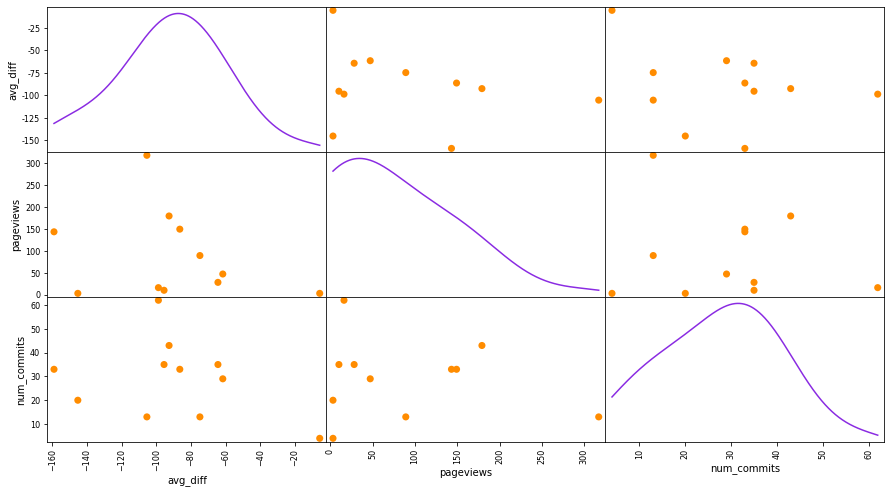

In [10]:
scatter_matrix(df,
               s=200,
               alpha = 1,
               color='#FF8C00',
               density_kwds = {'color': '#8A2BE2'},
               linewidths = 3,
               figsize= (15, 8), 
               diagonal="kde")

«Верно ли, что если у пользователя меньше просмотров страницы, то он, скорее всего, имеет меньшее число коммитов?». 

Ответ: нет

«Верно ли, что если у пользователя меньше просмотров страницы, то, скорее всего, у него будет небольшое среднее значение дельты (разница между датой первого коммита и сроком сдачи лабораторного задания)?». 

Ответ: нет

«Верно ли, что существует много пользователей с небольшим количеством коммитов и мало пользователей с большим количеством коммитов?». 

Ответ: да.

«Верно ли, что существует много пользователей с небольшим средним значением дельты и мало пользователей с большим средним значением дельты?». 

Ответ: нет

In [11]:
data.close()

In [12]:
df.shape

(11, 3)